# **Recurrent Neural Networks - 필수 과제**

**LSTM**을 구현해봅시다!
<br><br><br>
**필요 사전 지식**:

- <u>PyTorch</u> (선택 과제 1)

<br>

**추가 사전 지식**: (알면 좋으나 몰라도 괜찮음)

- <u>Tokenization</u>, <u>Word Embedding</u> (선택 과제 2)

<br><br><br><br><br>

In [1]:
!pip install transformers
!pip install datasets

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset

from tqdm import tqdm

<br><br>

[Hugging Face](https://huggingface.co)에서 [Rotten Tomatoes dataset](https://huggingface.co/datasets/rotten_tomatoes)과 [pretrained BERT](https://huggingface.co/bert-base-uncased)의 tokenizer를 가져오겠습니다.

또 학습 부담을 줄이기 위해 pretrained BERT에 내장된 word embedding layer의 weight도 가져옵시다.

In [3]:
# https://huggingface.co/datasets/rotten_tomatoes
dataset = load_dataset("rotten_tomatoes")

# https://huggingface.co/bert-base-uncased
pretrained_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")   # Hugging Face's Transformers library가 제공하는 bert-base-uncased tokenizer # input text를 token으로 쪼갬
pretrained_embeddings = AutoModel.from_pretrained("bert-base-uncased").embeddings.word_embeddings
# AutoModel : 제공된 identifier (bert-based-uncased)에 기반하여 적절한 모델 아키텍쳐를 나타냄

<br><br>

기본 BERT는 token을 768차원 벡터로 embedding합니다. 우리의 작은 dataset과 작은 모델에게 768차원은 부담스러우니 PCA를 사용해 64차원으로 줄여줍시다.

In [4]:
nano_embed = torch.pca_lowrank(pretrained_embeddings.weight.detach(), q=64)[0]

# pretrained_embeddings.weight.detach() : pretrained_embedding으로부터 워드 임베딩 행렬 추출
# .detach() : computational graph로부터 텐서 분리 ??
# torch.pca_lowrank(input, q=64) : input data를 q = 64 차원으로 차원 축소
# [0] : PCA-transformed tensor

# nano_embed 차원 : 64
# BERT word embedding 차원 : 768

<br><br>

그런데 무작정 64차원으로 줄여도 되는 걸까요? BERT의 d_model이 괜히 768도 아닐 테고, 정보의 손실이 아주 클 것 같은데 말입니다.

궁금하니 코사인 유사도로 축소된 embedding layer에 token들의 정보가 그럭저럭 잘 남아있는지 확인해봅시다.

In [5]:
# 코사인 유사도를 통해 고차원 공간의 벡터와 저차원 임베딩 벡터의 유사도를 계산할 수 있음

cos = (nano_embed @ nano_embed.T) / (nano_embed.abs() @ nano_embed.abs().T)

In [6]:
# word에 다양한 값을 넣어보세요! tokenizer의 vocab에 없는 token에 대해서는 빈 list가 뜹니다.
word = "jackson"

# BERT의 pretrained tokenizer를 이용하여 word(jackson)과 가장 유사한 단어를 추출함

([*map(pretrained_tokenizer.decode, cos[pretrained_tokenizer.vocab[word]].argsort(descending=True)[1:21])] if word in pretrained_tokenizer.vocab else [])

['parkway',
 'mississippi',
 'kelly',
 'won',
 'since',
 'michigan',
 'jack',
 '##yn',
 'grabs',
 'taken',
 'taking',
 'twice',
 'minnesota',
 'democrats',
 'again',
 'winning',
 'pride',
 'pennsylvania',
 'lions',
 'kicker']

꽤 잘 남아있는 것 같습니다.

(TMI: 조금 더 욕심을 부려 한번 32차원으로 줄여보면 무시하기 어려운 정보의 손실을 체감할 수 있습니다.)

<br><br>

이제 LSTM을 구현합시다! 사실 원래 BiLSTM으로 하려고 했는데 underfitting이 심해서 그냥 plain LSTM으로 준비했습니다.

<br><br><br><br>
#### <span style="color:red">**<u>Q1.</u>**</span>

`class LSTMCell`의 빈칸을 채우세요.

In [7]:
class LSTMCell(nn.Module):
    def __init__(self, d_x, d_h): # d_x: x의 차원수 (scalar int)
                                  # d_h: h의 차원수 (scalar int)
        super().__init__()
        d_stack = d_x + d_h

        dim1 = d_x + d_h    # input gate의 input dim
        dim2 = d_h          # input gate의 ouput dim
        dim3 = d_x + d_h    # cell state의 input dim
        dim4 = d_h          # cell state의 output dim
        dim5 = d_x + d_h    # output gate의 input dim
        dim6 = d_h          # output gate의 output dim

        self.W_f = nn.Linear(d_stack, d_h)  # forget gate의 weight matrix
        self.W_i = nn.Linear(dim1, dim2)    # input gate의 weight matrix
        self.W_C = nn.Linear(dim3, dim4)    # cell state의 weight matrix
        self.W_o = nn.Linear(dim5, dim6)    # output gate의 weight matrix


    # forward는 t-1의 h_{t-1}, C_{t-1}과 t의 x_t를 입력으로 받아 계산합니다.

    def forward(self, x, h, C): # x: x_t
                                # h: h_{h-1}
                                # C: C_{t-1}
        stack = torch.cat([x, h])

        f =  torch.sigmoid(self.W_f(stack))
        i =  torch.sigmoid(self.W_i(stack))
        C_ = self.W_C(stack).tanh()

        C_t = f * C + i * C_

        o =  torch.sigmoid(self.W_o(stack))
        h_t = o * C_t.tanh()

        return h_t, C_t

In [8]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, d_out, pretrained_embeddings):
        '''
        vocab_size : 단어의 개수
        d_out : output dim.
        pretrained_embeddings : 워드 임베딩 층을 초기화하기 위한 pretrained word embeddding
        '''

        super().__init__()
        vocab_size = pretrained_embeddings.shape[0]
        d_h = d_model = pretrained_embeddings.shape[1]

        self.embed = nn.Embedding(vocab_size, d_model, _weight=pretrained_embeddings.clone()) # word embedding layer : 워드 인덱스를 워드 임베딩으로 전환
        self.cell = LSTMCell(d_x=d_model, d_h=d_h) # LSTM cell
        self.out = nn.Linear(d_h, d_out, bias=True) # output layer : LSTM hidden state와 최종 output과 연결

        self.h_init = nn.Parameter(torch.zeros(d_h), requires_grad=False) # initial h : 파라미터를 0으로 초기화함
        self.C_init = nn.Parameter(torch.zeros(d_h), requires_grad=False) # initial C

    def forward(self, input_ids):
        embedded = self.embed(input_ids).squeeze()

        h = self.h_init.clone() # h 초기화
        C = self.C_init.clone() # C 초기화
        for x in embedded:
            h, C = self.cell(x, h, C) # iterate over embedded sequence

        return self.out(h).squeeze() # last hidden state를 output layer에 통과시킨 값을 반환

<br><br><br><br>
#### <span style="color:red">**<u>Q2.</u>**</span>

Test accuracy가 0.7 이상이 되도록 모델을 훈련시키세요.

In [9]:
######################### START OF YOUR CODE #########################

# 필요에 따라 바꿔도 됩니다.
device = "cuda"

########################## END OF YOUR CODE ##########################

model = LSTM(vocab_size=pretrained_tokenizer.vocab_size, d_out=1, pretrained_embeddings=nano_embed).to(device)

In [10]:
######################### START OF YOUR CODE #########################

# learning rate을 적절히 수정해보세요.
lr = 2.5e-03

########################## END OF YOUR CODE ##########################

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [11]:
train_loader = DataLoader(dataset["train"], shuffle=True)

In [12]:
num_print = 500
num_batch = 10

# List to store loss value
loss_values = []


# train

save_l = 0
optimizer.zero_grad()


for i, data in enumerate(tqdm(train_loader)):
    text, label = data["text"][0], data["label"][0]
    input_ids = pretrained_tokenizer.encode(text, return_tensors="pt").to(device)
    y_pred = model(input_ids)

    label = label.to(device) * 1.
    loss = criterion(y_pred, label)
    loss.backward()

    if not (i+1)%num_batch:
        optimizer.step()
        optimizer.zero_grad()

    save_l += loss.item()

    # append loss value
    loss_values.append(loss.item())

    if not (i+1)%num_print:
        print(f"{i+1:>5} iter: {save_l/num_print}")
        save_l = 0

  6%|▌         | 505/8530 [00:14<03:29, 38.35it/s]

  500 iter: 0.6974375984668731


 12%|█▏        | 1005/8530 [00:28<03:16, 38.33it/s]

 1000 iter: 0.6923452249765396


 18%|█▊        | 1506/8530 [00:43<03:23, 34.58it/s]

 1500 iter: 0.6688418378233909


 24%|██▎       | 2006/8530 [00:58<02:37, 41.51it/s]

 2000 iter: 0.6566415005624294


 29%|██▉       | 2505/8530 [01:12<02:42, 37.09it/s]

 2500 iter: 0.639109272480011


 35%|███▌      | 3006/8530 [01:27<02:22, 38.73it/s]

 3000 iter: 0.5924060068130493


 41%|████      | 3506/8530 [01:41<02:04, 40.24it/s]

 3500 iter: 0.6331566034555435


 47%|████▋     | 4003/8530 [01:55<02:00, 37.46it/s]

 4000 iter: 0.6208857785910368


 53%|█████▎    | 4504/8530 [02:10<01:37, 41.34it/s]

 4500 iter: 0.5858930350840091


 59%|█████▊    | 5005/8530 [02:24<01:54, 30.87it/s]

 5000 iter: 0.575037311270833


 65%|██████▍   | 5504/8530 [02:38<01:17, 39.24it/s]

 5500 iter: 0.5592440562546254


 70%|███████   | 6009/8530 [02:53<01:02, 40.45it/s]

 6000 iter: 0.5812840927392244


 76%|███████▌  | 6504/8530 [03:07<00:56, 36.05it/s]

 6500 iter: 0.5389042174965143


 82%|████████▏ | 7003/8530 [03:22<00:41, 36.40it/s]

 7000 iter: 0.5502943687587977


 88%|████████▊ | 7508/8530 [03:36<00:25, 40.21it/s]

 7500 iter: 0.5351800694465637


 94%|█████████▍| 8008/8530 [03:50<00:12, 43.17it/s]

 8000 iter: 0.5285812260359526


100%|█████████▉| 8506/8530 [04:05<00:00, 36.09it/s]

 8500 iter: 0.5231588250100613


100%|██████████| 8530/8530 [04:06<00:00, 34.67it/s]


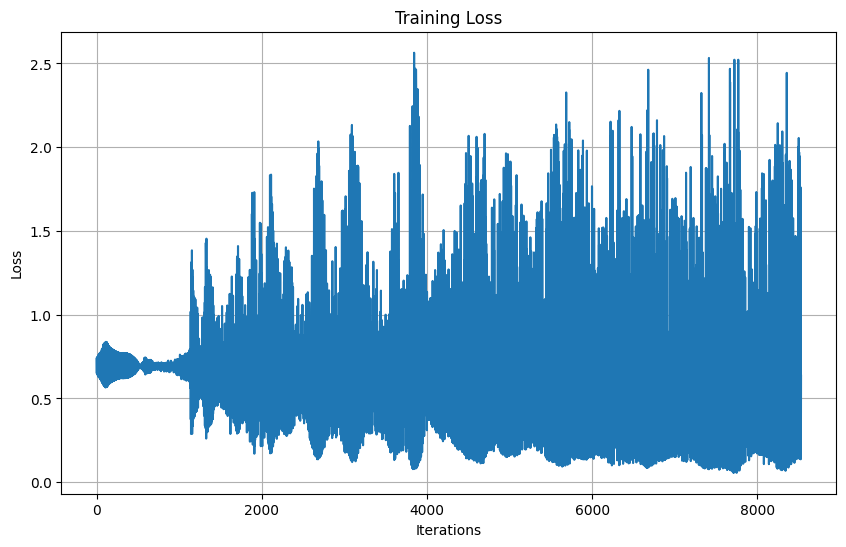

In [13]:
# plot loss

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# 손실함수를 그려서 학습 과정을 시각화함

plt.figure(figsize = (10, 6))
plt.plot(loss_values, label = 'Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

In [14]:
test_loader = DataLoader(dataset["test"], shuffle=True)


# test

res = torch.tensor(0)
with torch.no_grad():
    for i, data in enumerate(tqdm(test_loader)):
        text, label = data["text"][0], data["label"][0]
        input_ids = pretrained_tokenizer.encode(text, return_tensors="pt").to(device)
        y_pred = model(input_ids)
        res += ((1 if y_pred > 0 else 0) == label)

print("Test accuracy:", res.item() / dataset["test"].num_rows)

100%|██████████| 1066/1066 [00:10<00:00, 101.13it/s]

Test accuracy: 0.7420262664165104


In [15]:
# 관찰용
# n 값을 바꿔가며 훈련시킨 모델의 예측값을 구경해보세요
n = 589

print(dataset["test"][n])
with torch.no_grad():
    print(model(pretrained_tokenizer.encode(dataset["test"][n]["text"], return_tensors="pt").to(device)).sigmoid().item())

{'text': 'return to never land is much more p . c . than the original version ( no more racist portraits of indians , for instance ) , but the excitement is missing .', 'label': 0}
0.17686238884925842
